In [9]:
using TimeSeries
using DataFrames
import Proj4
using Optim
using Distances
using Statistics
using Printf
import JSON
;

In [14]:
using GaussianProcesses
using GaussianProcesses: set_params!
using TempModel

In [4]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [10]:
ICAO = "KJAN"
GPmodel = "matern"
save_dir="/Volumes/Samsung250GB/saved"
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", "crossval", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO

In [18]:
function showkernel(kdict, logNoise)
    print("k₁: Periodic \n=================\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:time1].σ2)
    Printf.@printf("l: %5.3f\n", √kdict[:time1].ℓ2)
    Printf.@printf("p: %5.0f hours\n", kdict[:time1].p)
    print("> spatial decay:\n")
    Printf.@printf("l: %5.3f km\n", kdict[:space1].ℓ / 1000)
    print("\nk₂: RQIso \n=================\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:time2].σ2)
    Printf.@printf("l: %5.3f hours\n", √kdict[:time2].ℓ2)
    Printf.@printf("α: %5.3f\n", kdict[:time2].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp2.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space2].ℓ / 1000)
    print("\nk₃: RQIso \n=================\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:time3].σ2)
    Printf.@printf("l: %5.3f hours\n", √kdict[:time3].ℓ2)
    Printf.@printf("α: %5.3f\n", kdict[:time3].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp3.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space3].ℓ / 1000)
    print("\nk₄: RQIso \n=================\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:time4].σ2)
    Printf.@printf("l: %5.3f days\n", √kdict[:time4].ℓ2 / 24)
    Printf.@printf("α: %5.3f\n",  kdict[:time4].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp4.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space4].ℓ / 1000)
    print("\n=================\n")
    Printf.@printf("σy: %5.3f °C\n", exp(logNoise))
end

showkernel (generic function with 1 method)

In [19]:
kdict = TempModel.kernel_sptemp_matern(;kmean=true)
hyp = output_dictionary["hyp"]
set_params!(kdict[:spatiotemporal], hyp[2:end])
showkernel(kdict, hyp[1])

k₁: Periodic 
σ: 4.072 °C
l: 0.586
p:    24 hours
> spatial decay:
l: 8412.150 km

k₂: RQIso 
σ: 1.062 °C
l: 0.310 hours
α: 0.058
> spatial decay:
l: 30.824 km

k₃: RQIso 
σ: 1.112 °C
l: 1.861 hours
α: 0.906
> spatial decay:
l: 90.596 km

k₄: RQIso 
σ: 3.672 °C
l: 0.252 days
α: 0.929
> spatial decay:
l: 844.263 km

σy: 0.160 °C


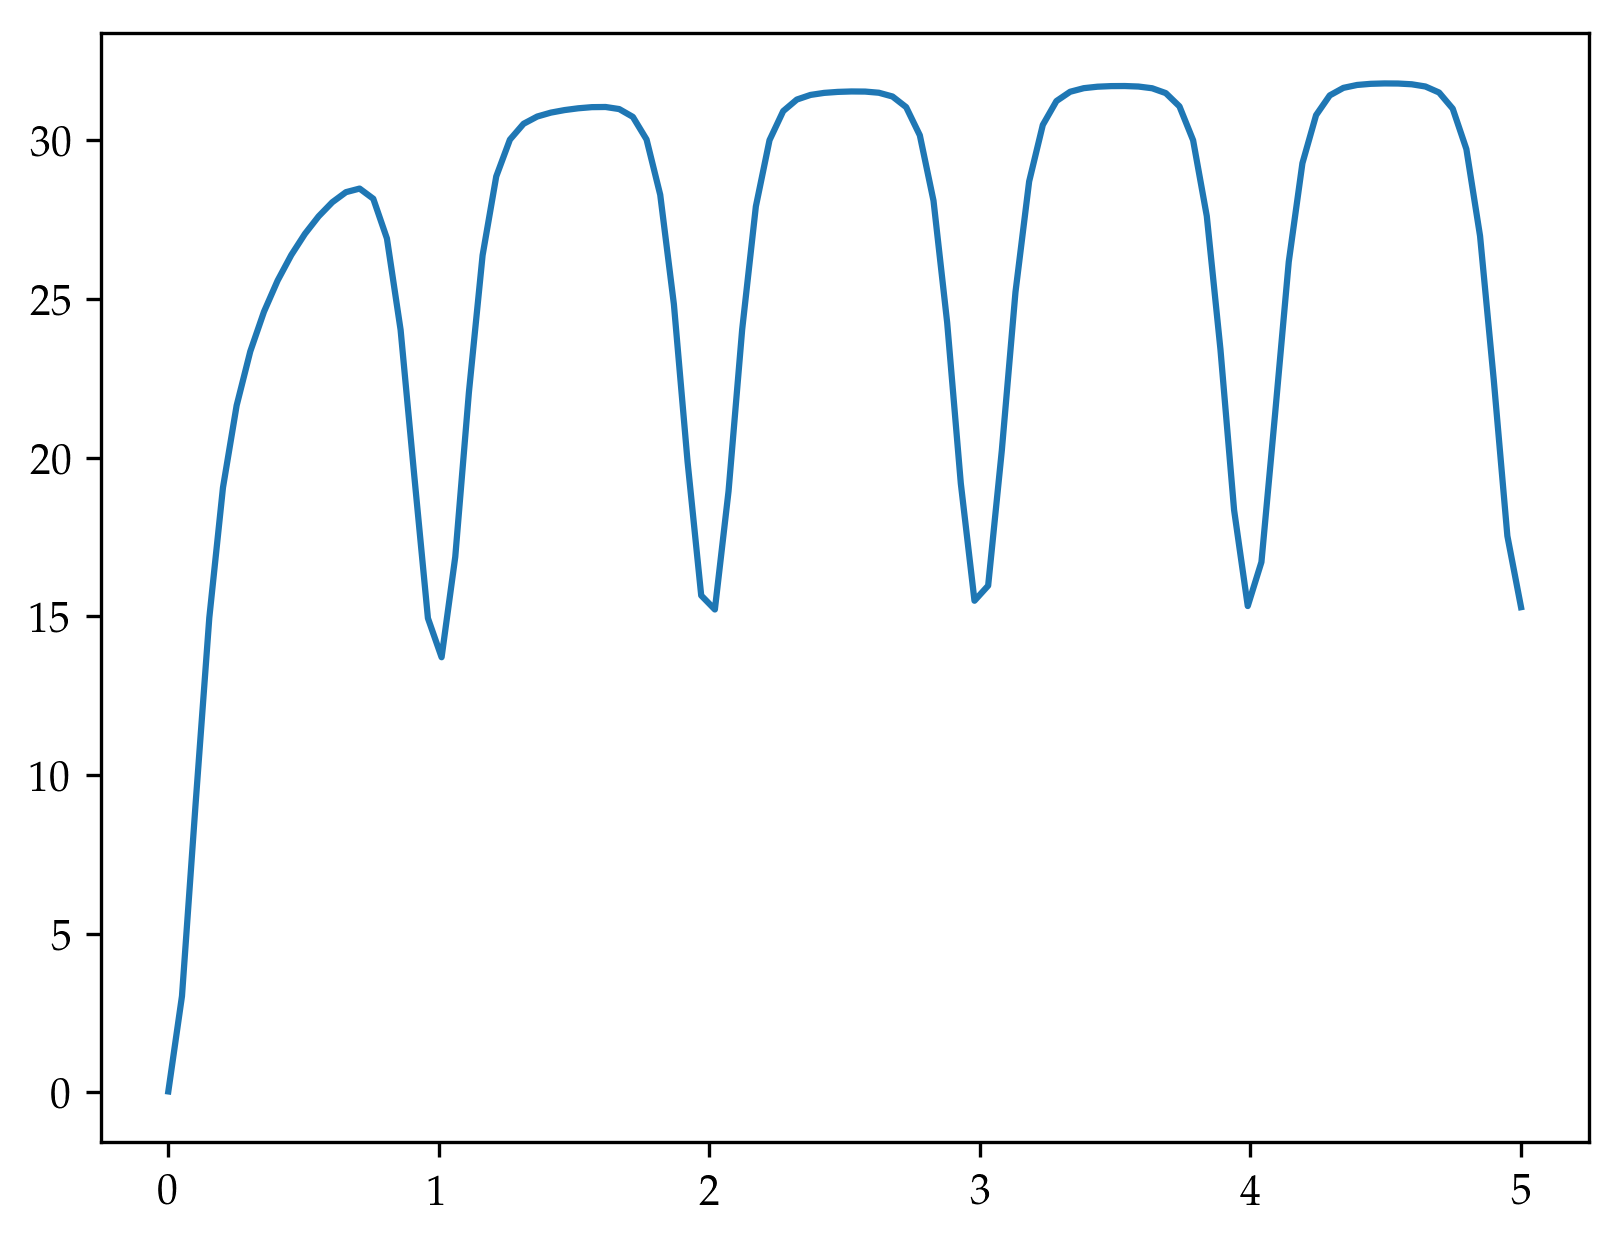

In [20]:
σ2_y = exp(2*hyp[1])
rr = range(0.0, stop=24*5, length=100)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="fitted variogram")
;